# Chat With Tools

In [1]:
import torch
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel, LoraConfig

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings, ChatHuggingFace
from langchain.tools import tool

from langchain.schema import AIMessage, HumanMessage
from langchain_core.messages import SystemMessage, AnyMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableConfig, Runnable
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, Any, Dict, Optional, TypedDict, Union, List
from lightning import Fabric

from IPython.display import display, Markdown, Image, SVG
from os import walk

### Set mixed precision

In [2]:
torch.set_float32_matmul_precision("medium")
fabric = Fabric(accelerator="cuda", devices=1, precision="bf16-mixed")
device = fabric.device
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


## RAG

### Load Embedding Data

In [3]:
embed_model_name = "sentence-transformers/all-mpnet-base-v2"

embeddings = HuggingFaceEmbeddings(model_name=embed_model_name)

### Load vector store

In [4]:
vector_store = FAISS.load_local(
    "./faiss_dnd_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True
)
retriever = vector_store.as_retriever()

### Mock data

In [5]:
n_users = 10

data = {
    "user_id": [f"user_{i+1}" for i in range(n_users)],
    "name": [f"User{i+1}" for i in range(n_users)],
    "age": np.random.randint(18, 60, size=n_users),
    "email": [f"user{i+1}@example.com" for i in range(n_users)],
    "num_posts": np.random.randint(0, 500, size=n_users),
    "num_likes": np.random.randint(0, 10000, size=n_users),
    "num_followers": np.random.randint(0, 100000, size=n_users),
    "num_following": np.random.randint(0, 5000, size=n_users),
}

df = pd.DataFrame(data)
display(df)

,user_id,name,age,email,num_posts,num_likes,num_followers,num_following
0,user_1,User1,59,user1@example.com,184,4024,86631,2792
1,user_2,User2,19,user2@example.com,129,4639,60658,698
2,user_3,User3,18,user3@example.com,233,3548,45932,1485
3,user_4,User4,52,user4@example.com,47,4847,62884,3046
4,user_5,User5,45,user5@example.com,387,4939,82907,1298
5,user_6,User6,43,user6@example.com,370,1117,4926,291
6,user_7,User7,51,user7@example.com,213,7811,5188,3251
7,user_8,User8,23,user8@example.com,128,3152,25513,394
8,user_9,User9,51,user9@example.com,36,3673,37239,2764
9,user_10,User10,23,user10@example.com,142,3576,27109,2979


## Functions

In [6]:
@tool
def spell_retrieve(query: str) -> str:
    """Retrieve information about dungeons and dragons spell.
    
    Args:
        query (str): The spell name to search for.

    Returns:
        str: The spell information.
    """
    retrieved_docs = vector_store.similarity_search(query, k=3)

    contents = "\n\n".join(
        (f"{doc.page_content}")
        for doc in retrieved_docs
    )
    
    return contents

@tool
def user(name: str) -> str:
    """
    User infomation retreiver

    Args:
        name (str): The name of user.

    Returns:
        str: The user information.
    """
    return f'{df[df['name'] == name]}.'

tools = [
    spell_retrieve,
    user
]

## Workflow

```
[User Message] 
     ↓
[xLAM-2] → [Check if Tool Call is Required] 
     ├── No → [Return to Llama 3 with "No tool needed"]
     └── Yes → [Detect Tool to Call] → [Prepare Structured Tool Call] → [Execute Tool] → [Send Result to Llama 3]
                          ↓
               [Llama 3] → [Generate Final Natural Reply]
     ↓
[Final reply to User]
```

## Custom Sate

In [7]:
class State(TypedDict):
    name: str
    stat: str
    messages: Annotated[list[AnyMessage], add_messages]
    context: str

## Tool Calling Class

In [8]:
class ToolCallRequest(TypedDict):
    """A typed dict that shows the inputs into the invoke_tool function."""

    name: str
    arguments: Dict[str, Any]

In [9]:
class ToolCalling():
    def __init__(self, model_name: str, tools: list[BaseTool]):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cpu")
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=512,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)
        self.rendered_tools = [convert_to_openai_tool(f) for f in tools]

    def invoke_tool(
            self,
            tool_call_request: Union[ToolCallRequest, List[ToolCallRequest]], 
            config: Optional[RunnableConfig] = None
    ):
        """A function that we can use the perform a tool invocation.

        Args:
            tool_call_request: a dict that contains the keys name and arguments.
                The name must match the name of a tool that exists.
                The arguments are the arguments to that tool.
            config: This is configuration information that LangChain uses that contains
                things like callbacks, metadata, etc.See LCEL documentation about RunnableConfig.

        Returns:
            output from the requested tool
        """

        print("Tool call request:", tool_call_request)
        
        # Sometimes the model outputs a list of tool call requests, 
        # so I loop each tool call and append to list
        
        if isinstance(tool_call_request, list):
            output = list()

            for tool_call in tool_call_request:
                tool_name_to_tool = {tool.name: tool for tool in tools}
                name = tool_call["name"]
                requested_tool = tool_name_to_tool[name]
                output.append(requested_tool.invoke(tool_call["arguments"], config=config))
            return output
        
        tool_name_to_tool = {tool.name: tool for tool in tools}
        name = tool_call_request["name"]
        requested_tool = tool_name_to_tool[name]
        return requested_tool.invoke(tool_call_request["arguments"], config=config)
    
    def invoke(self, state: State) -> List[str]:
        system_prompt = SystemMessage(f"""\
        You are an assistant that has access to the following set of tools. 
        Here are the names and descriptions for each tool:

        {self.rendered_tools}

        Given the user input, return the name and input of the tool to use. 
        Return your response as a JSON blob with 'name' and 'arguments' keys.

        The `arguments` should be a dictionary, with keys corresponding 
        to the argument names and the values corresponding to the requested values.
        """)

        chain = self.chat | JsonOutputParser() | self.invoke_tool
        messages = [system_prompt] + [state['messages'][-1]]

        try:
            response = chain.invoke(messages)
        except Exception as e:
            print("Error invoking tool:", e)
            response = ["No tool needed"]

        if not response:
            response = ["No tool needed"]
        
        return {"context": AIMessage(response)}

### ToolCalling Class Usage

In [10]:
tool_calling_model_name = "Salesforce/Llama-xLAM-2-8b-fc-r"

tool_calling = ToolCalling(
    model_name=tool_calling_model_name,
    tools=tools
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cpu


In [11]:
def tool(state: State) -> str:
    return tool_calling.invoke(state)

graph = StateGraph(State)
graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)
graph.add_edge("tool call", END)

graph = graph.compile()

In [12]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj"],
    lora_dropout=0.2,
    bias="none",
    task_type="CAUSAL_LM"
)

## Llama-3 Chat Class

In [ ]:
class LlamaChat():
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, load_in_4bit=True)
        self.adapter_model_name = './weight/best'
        self.model = PeftModel.from_pretrained(self.model, self.adapter_model_name)
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=2048,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)

    def generate(self, state: State) -> Dict[str, Any]:
        system_message_content = (
            "<|begin_of_text|>\n"
            "<|start_header_id|>system<|end_header_id|>\n"
            "You are a highly skilled Dungeon Master (DM) for Dungeons & Dragons 5th Edition. "
            "Your job is to read the player’s input and reply with an immersive, clear, and engaging narration that advances the story and game mechanics.\n"
            "\n"
            "Advice for the DM:\n"
            "  - Describe scenes with vivid sensory details and atmosphere.\n"
            "  - Offer meaningful choices if players ask for choices; respect player agency and avoid railroading.\n"
            "  - Keep secret die rolls hidden; reveal only the results and their effects.\n"
            "  - Use rules faithfully but prioritize fun and pacing over strict book-keeping.\n"
            "  - Improvise when players surprise you, but maintain internal consistency.\n"
            "  - Avoid technical jargon in your narration—stay in character and tone.\n"
            "\n"
            "Basic D&D 5e Rules Summary:\n"
            "  - Initiative: roll a d20 + Dexterity modifier to determine turn order.\n"
            "  - Actions: on your turn you can take one Action, one Bonus Action (if available), and move up to your speed.\n"
            "  - Reactions: special actions triggered outside your turn, such as Opportunity Attacks.\n"
            "  - Advantage & Disadvantage: roll two d20s; take the higher roll for advantage or the lower for disadvantage.\n"
            "  - Spellcasting: consumes spell slots; cantrips are cast at will; concentration holds one spell at a time.\n"
            "<|eot_id|>\n"
            "This is the retrieved context:\n\n"
            f"{state['context']}\n\n"
            "When you answer the player, you must respond in proper markdown format: heading, table, bold, italic, paragraph, blockquotes.\n"
        )

        print('State:', state)
        print('Context:', state["context"])
        print('Generating response ...')

        conversation_messages = [
            message
            for message in state["messages"]
            if message.type in ("human", "system")
            or (message.type == "ai" and not message.tool_calls)
        ]

        prompt = [SystemMessage(system_message_content)] + conversation_messages

        response = self.chat.invoke(prompt)
        
        return {"messages": [response]}

### LlamaChat Class Usage

In [14]:
llama_model_name = "meta-llama/Llama-3.1-8B-Instruct"

llama = LlamaChat(model_name=llama_model_name)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/yuaylong/miniconda3/envs/nlp/lib/python3.12/site-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Device set to use cuda:0


In [15]:
# text = "<|start_header_id|>player_1<|end_header_id|>\nCan I cast meteor swarm?<|eot_id|>"

# input_state = {
#     "name": "player_1",
#     "messages": [
#         HumanMessage(content=text)
#     ],
#     "context": ""
# }

# response = llama.generate(state=input_state)
# print(response)

## LangGraph Demo

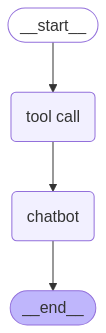

In [16]:
def tool(state: State):
    return tool_calling.invoke(state)

def chatbot(state: State) -> str:
    return llama.generate(state=state)

memory = MemorySaver()

graph = StateGraph(State)

graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)

graph.add_edge("tool call", "chatbot")

graph.add_node("chatbot", chatbot)
graph.add_edge("chatbot", END)

graph = graph.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": "123"}}

text = "<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": ""
}

for step in graph.stream(
    input_state,
    config=config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

<|start_header_id|>player_3<|end_header_id|>
Currently I am level 1 wizard.
Can I cast meteor swarm?<|eot_id|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'spell_retrieve', 'arguments': {'query': 'meteor swarm'}}]
================================ Human Message =================================

<|start_header_id|>player_3<|end_header_id|>
Currently I am level 1 wizard.
Can I cast meteor swarm?<|eot_id|>
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='b96df328-8477-4e97-a633-11724d770a85')], 'context': AIMessage(content=["# Meteor Swarm\n## Spell Name\nMeteor Swarm  \n![](https://static.wikia.nocookie.net/dnd-5e/images/9/99/Meteor.png/revision/latest/scale-to-width-down/225?cb=20221130233621)\n![](https://static.wikia.nocookie.net/dnd-5e/images/9/99/Meteor.png/revision/latest/scale-to-width-down/225?cb=20221130233621)  \nFrom Player's Handbook, page 259.\n## Description\n*9th-level evocation*\n* **Casting Time:** 1 action\n* **Range:**

In [18]:
text = "<|start_header_id|>player_3<|end_header_id|>\nCan you give me infomation of name User3?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": ""
}

for step in graph.stream(
    input_state,
    config=config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

<|start_header_id|>player_3<|end_header_id|>
Can you give me infomation of name User3?<|eot_id|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'User3'}}]
================================ Human Message =================================

<|start_header_id|>player_3<|end_header_id|>
Can you give me infomation of name User3?<|eot_id|>
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='b96df328-8477-4e97-a633-11724d770a85'), AIMessage(content="**Meteor Swarm is Not Available**\n================================\n\nYou're still a young wizard, and Meteor Swarm is a 9th-level evocation spell. As a level 1 wizard, you're not yet powerful enough to cast this spell.\n\nYou can consider learning more spells from the Wizard spell list as you gain levels and become more proficient in the arcane arts.\n\n**Current Spells Available**\n---------------------------\n\nAs a level 1 wizard, you know four cantrips and

In [19]:
input_message = "<|start_header_id|>player1<|end_header_id|>\nMy name is Tsubasa.<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=input_message)
    ],
    "context": ""
}

for step in graph.stream(
    input_state,
    config=config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

<|start_header_id|>player1<|end_header_id|>
My name is Tsubasa.<|eot_id|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'Tsubasa'}}]
================================ Human Message =================================

<|start_header_id|>player1<|end_header_id|>
My name is Tsubasa.<|eot_id|>
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='b96df328-8477-4e97-a633-11724d770a85'), AIMessage(content="**Meteor Swarm is Not Available**\n================================\n\nYou're still a young wizard, and Meteor Swarm is a 9th-level evocation spell. As a level 1 wizard, you're not yet powerful enough to cast this spell.\n\nYou can consider learning more spells from the Wizard spell list as you gain levels and become more proficient in the arcane arts.\n\n**Current Spells Available**\n---------------------------\n\nAs a level 1 wizard, you know four cantrips and have learned the fol

In [20]:
input_message = "<|start_header_id|>player1<|end_header_id|>\nhello, What is my name?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=input_message)
    ],
    "context": ""
}

for step in graph.stream(
    input_state,
    config=config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

<|start_header_id|>player1<|end_header_id|>
hello, What is my name?<|eot_id|>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'user', 'arguments': {'name': 'player1'}}]
================================ Human Message =================================

<|start_header_id|>player1<|end_header_id|>
hello, What is my name?<|eot_id|>
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nCurrently I am level 1 wizard.\nCan I cast meteor swarm?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='b96df328-8477-4e97-a633-11724d770a85'), AIMessage(content="**Meteor Swarm is Not Available**\n================================\n\nYou're still a young wizard, and Meteor Swarm is a 9th-level evocation spell. As a level 1 wizard, you're not yet powerful enough to cast this spell.\n\nYou can consider learning more spells from the Wizard spell list as you gain levels and become more proficient in the arcane arts.\n\n**Current Spells Available**\n---------------------------\n\nAs a level 1 wizard, you know four cantrips and have learned the